In [1]:
!pwd

/Users/kevinli/src/Python_For_Data_Science/Kevin/Homework4


In [3]:
!ls

50_categories
50_categories.tar.gz
HW4-V1.ipynb
hw_4-machine-learning-parallel-strawman.py


### Libraries 

In [8]:
import os
from six.moves import cPickle 

In [2]:
import cv2

In [3]:
import warnings
import sys
from glob import glob

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import KFold
from sklearn import preprocessing

In [6]:
import skimage.exposure
import skimage.feature
import skimage.filters
import skimage.filters.rank
import skimage.io
import skimage.morphology


### Loading Data

In [9]:
def load_image(img_path, n=400):
    """Load an image from file, and perform minimal processing on it to
    prepare it for feature extraction.

    Specifically, this function does the following operations:

        1) Load image
        2) Convert to RGB if grayscale
        3) Equalize histograms
        4) Denoise
        5) Resize

    Parameters
    ----------
    img_path : string
        The path to the image
    n : int (optional)
        The size to scale the largest dimension to

    Returns
    -------
    img : numpy.ndarray

    """
    # load the image from file
    img = skimage.io.imread(img_path).astype('f8')
    # make sure it has three channels
    if img.ndim == 2:
        img = img[:, :, None] * np.ones(img.shape + (3,))

    # equalize histograms
    img = skimage.exposure.equalize_hist(img)
    # reduce noise
    img = skimage.filters.denoise_bilateral(img, 3, 0.1)

    # scale largest dimension to be of size n
    shape = img.shape[:2]
    scale = float(n) / max(shape)
    img = skimage.transform.rescale(img, scale)
    shape = img.shape[:2]

    return img


In [9]:
glob("./50_categories/*/*.jpg")

['./50_categories/airplanes/airplanes_0001.jpg',
 './50_categories/airplanes/airplanes_0002.jpg',
 './50_categories/airplanes/airplanes_0003.jpg',
 './50_categories/airplanes/airplanes_0004.jpg',
 './50_categories/airplanes/airplanes_0005.jpg',
 './50_categories/airplanes/airplanes_0006.jpg',
 './50_categories/airplanes/airplanes_0007.jpg',
 './50_categories/airplanes/airplanes_0008.jpg',
 './50_categories/airplanes/airplanes_0009.jpg',
 './50_categories/airplanes/airplanes_0010.jpg',
 './50_categories/airplanes/airplanes_0011.jpg',
 './50_categories/airplanes/airplanes_0012.jpg',
 './50_categories/airplanes/airplanes_0013.jpg',
 './50_categories/airplanes/airplanes_0014.jpg',
 './50_categories/airplanes/airplanes_0015.jpg',
 './50_categories/airplanes/airplanes_0016.jpg',
 './50_categories/airplanes/airplanes_0017.jpg',
 './50_categories/airplanes/airplanes_0018.jpg',
 './50_categories/airplanes/airplanes_0019.jpg',
 './50_categories/airplanes/airplanes_0020.jpg',
 './50_categories/ai

In [10]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "
//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):


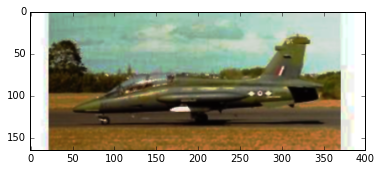

In [69]:
img = load_image('./50_categories/airplanes/airplanes_0001.jpg')
img.shape
plt.imshow(img)

In [70]:
img.shape

(165, 400, 3)

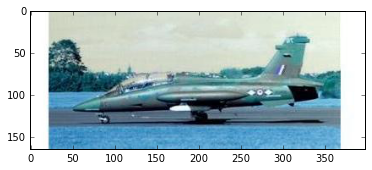

In [71]:
img = cv2.imread('./50_categories/airplanes/airplanes_0001.jpg')
img.shape
plt.imshow(img)

In [73]:
img.shape # Lost some dimensions ... Weird 

(164, 398, 3)

In [64]:
img.shape # using skimage seems more reliable

(165, 400, 3)

In [65]:
RGB = img.reshape((-1, 3)).T

In [66]:
RGB.shape

(3, 66000)

In [10]:
def extract_features(img):
    """Extract a vector of features from an image. The feature vector is
    flat, but has the following components:

        1) Mean of R, G, and B channels
        2) Covariance between R, G, and B channels
        3) Summary statistics of image entropy

    Parameters
    ----------
    img : numpy.ndarray
        The image to extract features from.

    Returns
    -------
    feature_vec : numpy.ndarray
        One-dimensional numpy array of features

    """
    RGB = img.reshape((-1, 3)).T

    # mean of each channel
    mean = np.mean(RGB, axis=1)
    # median of each channel
    median = np.median(RGB, axis=1)
    # covariance between channels
    cov = np.cov(RGB).ravel()
    # (normalized) entropy of the grayscale image
    entropy = skimage.filters.rank.entropy(
        np.mean(img, axis=-1).astype('uint16'),
        skimage.morphology.disk(5))
    entropy = entropy / float(img.size)
    entropy_sum = np.sum(entropy)
    entropy_mean = np.mean(entropy)
    entropy_var = np.var(entropy)
    
    # The luma Average (To be added)
    
    # concatenate all the features together
    feature_vec = np.concatenate(
        [mean, median, cov, [entropy_sum, entropy_mean, entropy_var]])

    return feature_vec

In [14]:
165*400

66000

In [15]:
img.shape

(165, 400, 3)

In [20]:
RGB = img.reshape((-1, 3)).T

# mean of each channel
mean = np.mean(RGB, axis=1)
# median of each channel
median = np.median(RGB, axis=1)

In [21]:
RGB.shape

(3, 66000)

In [17]:
mean.shape

(3,)

In [18]:
median.shape

(3,)

In [19]:
# covariance between channels
cov = np.cov(RGB).ravel()
cov

array([ 0.06212524,  0.06607057,  0.06933656,  0.06607057,  0.08494665,
        0.09305983,  0.06933656,  0.09305983,  0.10758637])

In [42]:
# (normalized) entropy of the grayscale image
entropy = skimage.filters.rank.entropy(
    np.mean(img, axis=-1).astype('uint16'),
    skimage.morphology.disk(5))
entropy = entropy / float(img.size)
entropy_sum = np.sum(entropy)
entropy_mean = np.mean(entropy)
entropy_var = np.var(entropy)

In [44]:
entropy.shape

(165, 400)

In [30]:
img.reshape((-1, 3)).T

array([[ 0.99447722,  0.99696967,  0.99696968, ...,  0.99696968,
         0.99696967,  0.99447722],
       [ 0.99447722,  0.99696967,  0.99696968, ...,  0.99696968,
         0.99696967,  0.99447722],
       [ 0.99447722,  0.99696967,  0.99696968, ...,  0.99696968,
         0.99696967,  0.99447722]])

In [33]:
(img.reshape((-1, 3)).T).shape

(3, 66000)

In [29]:
result = extract_features(img)
result.shape 

(18,)

In [11]:
def get_image_categories(images):
    """Get the true categories of a set of paths to images, based on the
    directory they are located in.

    The paths should have the form:
        path/to/image/category/image.jpg

    Where the image filename is the last item in the path, and the
    directory (category name) is the second to last item in the path.

    Parameters
    ----------
    images : list
        List of paths to images

    Returns
    -------
    categories : numpy.ndarray
        An array of integers in order of the images, corresponding to
        each image's category
    category_map : list
        A list of category names. The category integers in
        `categories` are indices into this list.

    """
    get_category = lambda x: os.path.split(os.path.split(x)[0])[1]
    categories = list(map(get_category, images))
    category_map = sorted(set(categories))
    categories = np.array(map(category_map.index, categories))
    return categories, category_map



In [12]:
all_images = glob("./50_categories/*/*.jpg")
len(all_images) # 4244 images in total

4244

In [127]:
type(get_image_categories(all_images))

tuple

In [13]:
def load_and_extract(images):
    # placeholder variable for feature array
    features = None

    # go through each image and calculate features, saving them in the
    # feature array
    for i, image_path in enumerate(images):
        # display progress
        msg = "[%d / %d] %s" % (i, len(images), image_path)
        sys.stdout.write(msg + "\r")
        sys.stdout.flush()

        # load and extract features
        img = load_image(image_path)
        img_features = extract_features(img)
        if i == 0:
            features = np.empty((len(images), img_features.size), dtype='f4')
            sys.stdout.write(" "*len(msg) + "\r")
            print("Feature array has shape %s" % str(features.shape))
        features[i] = img_features

        # clear the output (the \r moves the cursor back to the
        # beginning of the line, so we can overwrite it)
        sys.stdout.write(" "*len(msg) + "\r")

    return features


In [14]:
features = load_and_extract(all_images)

Feature array has shape (4244, 18)


//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "
//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "
//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):


//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "
//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "
//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):


//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "
//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "
//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):


//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "
//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "
//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):


//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "
//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "
//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):


//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "
//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "
//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):


//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "
//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "
//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):


//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "
//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "
//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):


//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "
//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "
//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):


//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "
//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "
//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):


//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "
//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "
//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):


//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "
//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "
//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):


//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "
//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):
//anaconda/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warnings.warn("This might be a color image. The histogram will be "


//anaconda/lib/python3.5/site-packages/skimage/restoration/_denoise.py:8: skimage_deprecation: Call to deprecated function ``denoise_bilateral``. Use ``skimage.restoration.denoise_bilateral`` instead.
  bins=10000, mode='constant', cval=0):


In [15]:
features.shape

(4244, 18)

In [16]:
# create an integer mapping to categories
categories, category_map = get_image_categories(all_images)

In [18]:
type(get_image_categories(all_images))

tuple

In [19]:
get_image_categories(all_images)

(array(<map object at 0x107e07f60>, dtype=object),
 ['airplanes',
  'bat',
  'bear',
  'blimp',
  'camel',
  'comet',
  'conch',
  'cormorant',
  'crab',
  'dog',
  'dolphin',
  'duck',
  'elephant',
  'elk',
  'frog',
  'galaxy',
  'giraffe',
  'goat',
  'goldfish',
  'goose',
  'gorilla',
  'helicopter',
  'horse',
  'hot-air-balloon',
  'hummingbird',
  'iguana',
  'kangaroo',
  'killer-whale',
  'leopards',
  'llama',
  'mars',
  'mussels',
  'octopus',
  'ostrich',
  'owl',
  'penguin',
  'porcupine',
  'raccoon',
  'saturn',
  'skunk',
  'snail',
  'snake',
  'speed-boat',
  'starfish',
  'swan',
  'teddy-bear',
  'toad',
  'triceratops',
  'unicorn',
  'zebra'])

In [35]:
categories

array(<map object at 0x1096a85f8>, dtype=object)

In [36]:
category_map

['airplanes',
 'bat',
 'bear',
 'blimp',
 'camel',
 'comet',
 'conch',
 'cormorant',
 'crab',
 'dog',
 'dolphin',
 'duck',
 'elephant',
 'elk',
 'frog',
 'galaxy',
 'giraffe',
 'goat',
 'goldfish',
 'goose',
 'gorilla',
 'helicopter',
 'horse',
 'hot-air-balloon',
 'hummingbird',
 'iguana',
 'kangaroo',
 'killer-whale',
 'leopards',
 'llama',
 'mars',
 'mussels',
 'octopus',
 'ostrich',
 'owl',
 'penguin',
 'porcupine',
 'raccoon',
 'saturn',
 'skunk',
 'snail',
 'snake',
 'speed-boat',
 'starfish',
 'swan',
 'teddy-bear',
 'toad',
 'triceratops',
 'unicorn',
 'zebra']

In [24]:
def get_image_categories(images):
    """Get the true categories of a set of paths to images, based on the
    directory they are located in.

    The paths should have the form:
        path/to/image/category/image.jpg

    Where the image filename is the last item in the path, and the
    directory (category name) is the second to last item in the path.

    Parameters
    ----------
    images : list
        List of paths to images

    Returns
    -------
    categories : numpy.ndarray
        An array of integers in order of the images, corresponding to
        each image's category
    category_map : list
        A list of category names. The category integers in
        `categories` are indices into this list.

    """
    get_category = lambda x: os.path.split(os.path.split(x)[0])[1]
    categories = list(map(get_category, images))
    category_map = sorted(set(categories))
    categories = np.array(list(map(category_map.index, categories)))
    return categories, category_map


In [25]:
# create an integer mapping to categories
categories, category_map = get_image_categories(all_images)

In [26]:
categories

array([ 0,  0,  0, ..., 49, 49, 49])

In [27]:
# concatenate the features (X) and categories (Y)
df = np.hstack([features, categories[:, None]])

In [28]:
df.shape

(4244, 19)

In [29]:
# save to disk
filename = "./image_dataset.npy"
np.save(filename, df)
print("Saved features to '%s'" % filename)

filename = "./image_categories.npy"
np.save(filename, category_map)
print("Saved categories to '%s'" % filename)

Saved features to './image_dataset.npy'
Saved categories to './image_categories.npy'


### Summary of all functions from feature generation

In [ ]:
"""Image processing and feature extraction

To compute features for training, run:

`python image_processing.py`.

This script assumes there is a directory called `50_categories`, which
contains subdirectories named by category, and then within each
subdirectory the actual images.

Running this script from the command line will load the images,
perform some basic preprocessing (equalizing, scaling, etc.), and
compute features. It will then save the feature array to a file called
`image_dataset.npy`, and the categories to a file called
`image_categories.npy` (these are both numpy files, and can be loaded
by calling `np.load`).

"""

# built-in
import os
import sys
from glob import glob
# external
import numpy as np
import skimage.exposure
import skimage.feature
import skimage.filters
import skimage.filters.rank
import skimage.io
import skimage.morphology


def load_image(img_path, n=400):
    """Load an image from file, and perform minimal processing on it to
    prepare it for feature extraction.

    Specifically, this function does the following operations:

        1) Load image
        2) Convert to RGB if grayscale
        3) Equalize histograms
        4) Denoise
        5) Resize

    Parameters
    ----------
    img_path : string
        The path to the image
    n : int (optional)
        The size to scale the largest dimension to

    Returns
    -------
    img : numpy.ndarray

    """
    # load the image from file
    img = skimage.io.imread(img_path).astype('f8')
    # make sure it has three channels
    if img.ndim == 2:
        img = img[:, :, None] * np.ones(img.shape + (3,))

    # equalize histograms
    img = skimage.exposure.equalize_hist(img)
    # reduce noise
    img = skimage.filter.denoise_bilateral(img, 3, 0.1)

    # scale largest dimension to be of size n
    shape = img.shape[:2]
    scale = float(n) / max(shape)
    img = skimage.transform.rescale(img, scale)
    shape = img.shape[:2]

    return img


def extract_features(img):
    """Extract a vector of features from an image. The feature vector is
    flat, but has the following components:

        1) Mean of R, G, and B channels
        2) Covariance between R, G, and B channels
        3) Summary statistics of image entropy

    Parameters
    ----------
    img : numpy.ndarray
        The image to extract features from.

    Returns
    -------
    feature_vec : numpy.ndarray
        One-dimensional numpy array of features

    """
    RGB = img.reshape((-1, 3)).T

    # mean of each channel
    mean = np.mean(RGB, axis=1)
    # median of each channel
    median = np.median(RGB, axis=1)
    # covariance between channels
    cov = np.cov(RGB).ravel()
    # (normalized) entropy of the grayscale image
    entropy = skimage.filter.rank.entropy(
        np.mean(img, axis=-1).astype('uint16'),
        skimage.morphology.disk(5))
    entropy = entropy / float(img.size)
    entropy_sum = np.sum(entropy)
    entropy_mean = np.mean(entropy)
    entropy_var = np.var(entropy)

    # concatenate all the features together
    feature_vec = np.concatenate(
        [mean, median, cov, [entropy_sum, entropy_mean, entropy_var]])

    return feature_vec


def get_image_categories(images):
    """Get the true categories of a set of paths to images, based on the
    directory they are located in.

    The paths should have the form:
        path/to/image/category/image.jpg

    Where the image filename is the last item in the path, and the
    directory (category name) is the second to last item in the path.

    Parameters
    ----------
    images : list
        List of paths to images

    Returns
    -------
    categories : numpy.ndarray
        An array of integers in order of the images, corresponding to
        each image's category
    category_map : list
        A list of category names. The category integers in
        `categories` are indices into this list.

    """
    get_category = lambda x: os.path.split(os.path.split(x)[0])[1]
    categories = list(map(get_category, images))
    category_map = sorted(set(categories))
    categories = np.array(list(map(category_map.index, categories)))
    return categories, category_map


def load_and_extract(images):
    # placeholder variable for feature array
    features = None

    # go through each image and calculate features, saving them in the
    # feature array
    for i, image_path in enumerate(images):
        # display progress
        msg = "[%d / %d] %s" % (i, len(images), image_path)
        sys.stdout.write(msg + "\r")
        sys.stdout.flush()

        # load and extract features
        img = load_image(image_path)
        img_features = extract_features(img)
        if i == 0:
            features = np.empty((len(images), img_features.size), dtype='f4')
            sys.stdout.write(" "*len(msg) + "\r")
            print("Feature array has shape %s" % str(features.shape))
        features[i] = img_features

        # clear the output (the \r moves the cursor back to the
        # beginning of the line, so we can overwrite it)
        sys.stdout.write(" "*len(msg) + "\r")

    return features


if __name__ == "__main__":
    # get the list of images
    images = glob("./50_categories/*/*.jpg")

    # compute feature matrix
    features = load_and_extract(images)

    # create an integer mapping to categories
    categories, category_map = get_image_categories(images)

    # concatenate the features (X) and categories (Y)
    df = np.hstack([features, categories[:, None]])

    # save to disk
    filename = "./image_dataset.npy"
    np.save(filename, df)
    print("Saved features to '%s'" % filename)

    filename = "./image_categories.npy"
    np.save(filename, category_map)
    print("Saved categories to '%s'" % filename)

# Random Forest Classifier


In [48]:
RandomForestClassifier?

In [54]:
df.shape

(4244, 19)

In [58]:
X = df[:, 0:18]
Y = df[:, -1]

In [59]:
X.shape

(4244, 18)

In [60]:
Y.shape

(4244,)

In [61]:
# Inputs for 
X = df[:, 1:18]
Y = df[:, -1]
# random state object
rso = np.random.RandomState(2384802)
# Building RandomForestClassifier
clf = RandomForestClassifier(
        n_estimators=50,
        n_jobs=-1,
        #compute_importances=True,
        random_state=rso)
clf.fit(X, Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False,
            random_state=<mtrand.RandomState object at 0x1096b2678>,
            verbose=0, warm_start=False)

### Feature Importances

In [62]:
importances = clf.feature_importances_

Feature ranking:
1. feature 13 (0.079182)
2. feature 0 (0.073324)
3. feature 9 (0.072519)
4. feature 4 (0.072181)
5. feature 1 (0.071891)
6. feature 2 (0.071393)
7. feature 3 (0.071284)
8. feature 5 (0.067852)
9. feature 11 (0.062172)
10. feature 12 (0.061738)
11. feature 10 (0.061469)
12. feature 7 (0.061228)
13. feature 8 (0.061169)
14. feature 6 (0.059428)
15. feature 14 (0.051148)
16. feature 15 (0.002021)
17. feature 16 (0.000000)


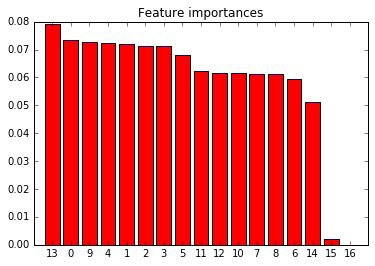

In [63]:
std = np.std([clf.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

The feature list was built as follows: 
[mean, median, cov, [entropy_sum, entropy_mean, entropy_var]])
1. Mean (R)
2. Mean (G)
3. Mean (B)
4. Median (R)
5. Median (G)
6. Median (B)
7. Cov (RR)
8. Cov (RG)
9. Cov (RB)
10. Cov (GR)
11. Cov (GG)
12. Cov (GB)
13. Cov (BR)
14. Cov (BG)
15. Cov (BB)
16. Entropy_Sum
17. Entropy_Mean
18. Entropy_Var

In [75]:
clf.estimator_params

('criterion',
 'max_depth',
 'min_samples_split',
 'min_samples_leaf',
 'min_weight_fraction_leaf',
 'max_features',
 'max_leaf_nodes',
 'random_state')

In [5]:
# %load hw_4-machine-learning-parallel-strawman.py
#!/usr/bin/env python
"""
AY 250 - Scientific Research Computing with Python
Homework Assignment 4 - Parallel Feature Extraction Example
Author: Christopher Klein, Joshua Bloom
"""
from os import listdir
from multiprocessing import Pool, cpu_count
from pylab import imread
from time import time

## CHANGE THIS NEXT LINE!
#MYDIRECTORY = "/Users/jbloom/Classes/ay250-py4sci/week4/50_categories"
MYDIRECTORY = "/Users/kevinli/src/Python_For_Data_Science/Kevin/Homework4/50_categories"
# FUNCTION DEFINITIONS
# Quick function to divide up a large list into multiple small lists, 
# attempting to keep them all the same size. 
def split_seq(seq, size):
        newseq = []
        splitsize = 1.0/size*len(seq)
        for i in range(size):
            newseq.append(seq[int(round(i*splitsize)):
                int(round((i+1)*splitsize))])
        return newseq
# Our simple feature extraction function. It takes in a list of image paths, 
# does some measurement on each image, then returns a list of the image paths
# paired with the results of the feature measurement.
def extract_features(image_path_list):
    feature_list = []
    for image_path in image_path_list:
        image_array = imread(image_path)
        feature = image_array.size # This feature is simple. You can modify this
        # code to produce more complicated features and to produce multiple
        # features in one function call.
        feature_list.append([image_path, feature])
    return feature_list



### Main program starts here ###################################################
# We first collect all the local paths to all the images in one list
image_paths = []
categories = listdir(MYDIRECTORY)
for category in categories:
    image_names = listdir(MYDIRECTORY  + "/" + category)
    for name in image_names:
        image_paths.append(MYDIRECTORY + "/" + category + "/" + name)

print ("There should be 4244 images, actual number is " + 
    str(len(image_paths)) + ".")

# Then, we run the feature extraction function using multiprocessing.Pool so 
# so that we can parallelize the process and run it much faster.
numprocessors = cpu_count() # To see results of parallelizing, set numprocessors
                            # to less than cpu_count().
# numprocessors = 1

# We have to cut up the image_paths list into the number of processes we want to
# run. 
split_image_paths = split_seq(image_paths, numprocessors)

# Ok, this block is where the parallel code runs. We time it so we can get a 
# feel for the speed up.
start_time = time()
p = Pool(numprocessors)
result = p.map_async(extract_features, split_image_paths)
poolresult = result.get()
end_time = time()

# All done, print timing results.
print ("Finished extracting features. Total time: " + 
    str(round(end_time-start_time, 3)) + " s, or " + 
    str( round( (end_time-start_time)/len(image_paths), 5 ) ) + " s/image.")
# This took about 10-11 seconds on my 2.2 GHz, Core i7 MacBook Pro. It may also
# be affected by hard disk read speeds.

# To tidy-up a bit, we loop through the poolresult to create a final list of
# the feature extraction results for all images.
combined_result = []
for single_proc_result in poolresult:
    for single_image_result in single_proc_result:
        combined_result.append(single_image_result)


NotADirectoryError: [Errno 20] Not a directory: '/Users/kevinli/src/Python_For_Data_Science/Kevin/Homework4/50_categories/.DS_Store'

## Using Keras

In [37]:
import numpy as np

from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import RMSprop
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.layers.convolutional import Convolution2D, MaxPooling2D


In [8]:
32*32

1024

In [30]:
!ls 50_categories/

airplanes       dolphin         gorilla         mars            snail
bat             duck            helicopter      mussels         snake
bear            elephant        horse           octopus         speed-boat
blimp           elk             hot-air-balloon ostrich         starfish
camel           frog            hummingbird     owl             swan
comet           galaxy          iguana          penguin         teddy-bear
conch           giraffe         kangaroo        porcupine       toad

crab            goldfish        leopards        saturn          unicorn
dog             goose           llama           skunk           zebra


In [31]:
a = np.ndarray([0, 1, 2, 3, 4, 5,  6])

array([], shape=(0, 1, 2, 3, 4, 5, 6), dtype=float64)

In [31]:
# Testing on the Iris Dataset

import numpy as np
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

In [32]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [60]:
# load dataset
dataframe = pandas.read_csv("iris.csv", header=None)
dataset = dataframe.values
X = dataset[:,0:4].astype(float)
Y = dataset[:,4]

In [61]:
# Encoding the Outpout Variable - One Hot Encoding
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

In [63]:
X.shape

(150, 4)

In [64]:
dataset.shape

(150, 5)

In [65]:
dummy_y.shape

(150, 3)

There is a Keras wrapper that allow us to use neural network models developed in Keras in Scikit Learn

In [66]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(4, input_dim=4, init='normal', activation='relu'))
    model.add(Dense(3, init='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [67]:
# Creating the KerasClassifier 
estimator = KerasClassifier(build_fn=baseline_model, nb_epoch=200, batch_size=5, verbose=0)

In [68]:
# Evaluate the model with k-fold cross validation
kfold = KFold(n=len(X), n_folds=10, shuffle=True, random_state=seed)

results = cross_val_score(estimator, X, dummy_y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 95.33% (4.27%)


# App The Methodology on the 50 Categories

In [37]:
# Repeating the same procedure of df (feature, response from the 50 categories)
df.shape

(4244, 19)

In [75]:
X = df[:, 0:18]
X.shape

(4244, 18)

In [76]:
Y = df[:, 18]
Y.shape

(4244,)

In [77]:
dummy_y = np_utils.to_categorical(Y)


//anaconda/lib/python3.5/site-packages/keras/utils/np_utils.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  Y = np.zeros((len(y), nb_classes))
//anaconda/lib/python3.5/site-packages/keras/utils/np_utils.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  Y[i, y[i]] = 1.


In [72]:
dummy_y.shape

(4244, 50)

In [78]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(18, input_dim=18, init='normal', activation='relu'))
    #model.add(Dense(28, input_dim=18, init='normal', activation='relu'))
    model.add(Dense(50, init='normal', activation = 'sigmoid'))
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return(model)

In [73]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(56, input_dim=18, init='normal', activation='relu'))
    model.add(Dense(28, input_dim=18, init='normal', activation='relu'))
    model.add(Dense(50, init='normal', activation = 'sigmoid'))
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return(model)

In [79]:
# Creating the KerasClassifier 
estimator = KerasClassifier(build_fn=baseline_model, nb_epoch=200, batch_size=5, verbose=0)
# Evaluate the model with k-fold cross validation
kfold = KFold(n=len(X), n_folds=10, shuffle=True, random_state=seed)

results = cross_val_score(estimator, X, dummy_y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 18.80% (2.25%)


# Another Model since the last one was terrible

In [80]:
# define baseline model
def baseline_model2():
    # create model
    model = Sequential()
    model.add(Dense(18, input_dim=18, init='normal', activation='relu'))
    model.add(Dense(36, init='normal', activation='relu'))
    model.add(Dense(72, init='normal', activation='relu'))
    #model.add(Dense(28, input_dim=18, init='normal', activation='relu'))
    model.add(Dense(50, init='normal', activation = 'sigmoid'))
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return(model)

In [81]:
# Creating the KerasClassifier 
estimator = KerasClassifier(build_fn=baseline_model2, nb_epoch=200, batch_size=5, verbose=0)
# Evaluate the model with k-fold cross validation
kfold = KFold(n=len(X), n_folds=10, shuffle=True, random_state=seed)

results = cross_val_score(estimator, X, dummy_y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 20.22% (1.52%)


## Data Pre-Processing and Data Augmentation

In order to make the most of our few training examples, we will "augment" them via a number of random transformations, so that our model would never see twice the exact same picture. This helps prevent overfitting and helps the model generalize better

In [39]:
from keras.preprocessing.image import ImageDataGenerator

keras.preprocessing.image.ImageDataGenerator allows you to configure random transformations and normalization operations to be done on your image data during training;
instantiate generators of augmented image batches

In [40]:
datagen = ImageDataGenerator(
            rotation_range=40,
            width_shift_range=0.2, 
            height_shift_range=0.2, 
            rescale=1./255,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest')

In [41]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [ ]:
datagen = ImageDataGenerator(
            rotation_range=40,
            width_shift_range=0.2, 
            height_shift_range=0.2, 
            rescale=1./255,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest')

img = load_img('data/train/cats/cat.0')

In [7]:
!ls

10Algorithms-08.pdf
50_categories
50_categories.tar.gz
DL_Method2.ipynb
HW4-V1.ipynb
data
hw_4-machine-learning-parallel-strawman.py
image_categories.npy
image_dataset.npy


## A neural network approach

In [24]:
# Practice Code
X = np.array([[0,0,1], [0,1,1], [1,0,1], [1,1,1]])
X

array([[0, 0, 1],
       [0, 1, 1],
       [1, 0, 1],
       [1, 1, 1]])

In [13]:
type(X)

numpy.ndarray

In [12]:
y = np.array([[0,1,1,0]]).T
y

array([[0],
       [1],
       [1],
       [0]])

In [14]:
type(y)

numpy.ndarray

In [15]:
syn0 = 2*np.random.random((3,4)) - 1
syn1 = 2*np.random.random((4,1)) - 1

In [16]:
syn0

array([[ 0.9365201 ,  0.8366684 , -0.8376953 ,  0.03650433],
       [ 0.38067608, -0.95971582,  0.18031306,  0.37328364],
       [-0.38174171,  0.03785338, -0.76539532,  0.17111965]])

In [17]:
syn0.shape

(3, 4)

In [18]:
syn1

array([[ 0.60454351],
       [ 0.75846967],
       [ 0.84906581],
       [ 0.29755983]])

In [19]:
syn1.shape

(4, 1)

In [23]:
for j in range(60000):
    l1 = 1/(1+np.exp(-(np.dot(X, syn0))))
    l2 = 1/(1+np.exp(-(np.dot(l1, syn1))))
    l2_delta = (y-l2)*(l2*(1-l2))
    l1_delta = l2_delta.dot(syn1.T)*(l1 * (1 - l1))
    syn1 += l1.T.dot(l2_delta)
    syn0 += X.T.dot(l1_delta)

In [26]:
for iter in range(10):
    print(iter)

0
1
2
3
4
5
6
7
8
9


## 2 layer Neural Network

In [28]:
import numpy as np

# sigmoid function
def nonlin(x, deriv=False):
    if(deriv==True):
        return x*(1-x)
    return 1/(1+np.exp(-x))

# input dataset
X = np.array([[0,0,1], [0,1,1], [1, 0, 1], [1, 1,1 ]])

# output dataset
y = np.array([[0,0,1,1]]).T

# seed random numbers to make calculation
# deterministic (just a good practice)
np.random.seed(1)

# initaizlie weights randomly with mean 0
syn0 = 2*np.random.random((3,1)) - 1

for iter in range(10000):
    # forward propagation
    l0 = X
    l1 = nonlin(np.dot(l0, syn0))
    
    # how much did we miss
    l1_error = y - l1
    
    # multiply how much we missed by the slope of the sigmoid at the values in l1
    l1_delta = l1_error * nonlin(l1, True)
    
    # update weights 
    syn0 += np.dot(l0.T, l1_delta)
    
print("Output After Training:", l1)


Output After Training: [[ 0.00966449]
 [ 0.00786506]
 [ 0.99358898]
 [ 0.99211957]]
